# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2025
## deadline: 12.2.2025 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Niko Itänen

Student number: 2110412

Student email: nmitan@utu.fi

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=7 (7NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 7-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 7NN model for the provided data set (refer to the lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 7NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 7-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.


- Plot of the graph C-index vs. distance parameter value. 


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [17]:
# Import all the needed libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


### Read in the datasets

In [18]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).

# Read input.csv
input = pd.read_csv('data/input.csv', header=None) # This is our data of input features

# Read output.csv
output = pd.read_csv('data/output.csv', names=['WaterP']) # This is our data of target features

# Read coordinates.csv
coordinates = pd.read_csv('data/coordinates.csv', names=['X', 'Y']) # This is the data of geographical coordinates

# We want to convert the coordinates from dataframe to numpy array.
coordinates_matrix = coordinates[['X', 'Y']].to_numpy()

# Print dimensions from all datasets
print('Input data dimensions: ', input.shape)
print('Output data dimensions: ', output.shape)
print('Coordinates data dimensions: ', coordinates.shape)

Input data dimensions:  (1691, 75)
Output data dimensions:  (1691, 1)
Coordinates data dimensions:  (1691, 2)


As we can see, all the measurements are well within the instructions we have given. There are 75 different features to use in the input data, one in the output and two in the coordinates. The number of rows is also the same for all datasets of 1691 rows.

### Standardization of the predictor features (input.csv)

In [19]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this.

# Z-score standardization
# StandardScaler() standardizes features by removing the mean and scaling to unit variance.
# Function works as following: z = (x - u) / s,
# where x is the feature, u is the mean of the feature, and s is the standard deviation of the feature.
scaler = StandardScaler()

# Fit the scaler to the input data
input = scaler.fit_transform(input)

# Because scaler returns a numpy array, I convert it back to a pandas dataframe.
input = pd.DataFrame(input)

# I print the first 5 rows to check if the standardization was successful.
print(input.head())

         0         1         2         3         4         5         6   \
0 -0.053196 -0.219296  0.210020  0.704425  0.339477  0.412638  0.331074   
1 -0.632098 -0.682804 -0.285522 -0.369542 -0.138305  2.489725  2.051755   
2 -0.674980 -0.597421 -0.568689 -0.983237 -0.828435 -0.496087 -0.451053   
3 -0.331927 -0.154649  1.307292  0.090730  0.419107  1.061728  0.956776   
4 -0.610657 -0.673046 -0.161636 -0.522966 -0.377196  0.672274  0.800351   

         7         8         9   ...        65        66        67        68  \
0 -0.034411 -0.184481  0.307345  ...  0.219541  0.539119 -0.645254 -0.519918   
1 -0.034411 -0.246906 -0.226797  ...  0.219541 -0.169259 -0.645254  2.475438   
2 -0.034411 -0.324938 -0.627405  ... -1.047724 -0.877636 -0.645254 -0.519918   
3 -0.034411 -0.301529 -0.360333  ... -1.047724 -0.877636 -0.645254 -0.519918   
4 -0.034411 -0.363954 -0.961244  ... -1.047724 -0.877636  2.098494  0.977760   

         69        70        71        72        73        74  
0 -0

### Functions and analysis code

In [20]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Here we want to implement the k-NN regression model.
def knn_regression(X_train, Y_train, X_test, k):
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean') # We want to use the euclidean distance as the metric
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    Y_pred = pd.DataFrame(Y_pred, columns=Y_train.columns)
    return Y_pred

# Create a function for Spatial-One-Leave-Out Cross-Validation (SLOOCV)
def sloocv(X, Y, coordinates_matrix, d, k=7):
    # Define the number of samples in the dataset.
    n_samples = X.shape[0]

    # Create an array where to store the predictions
    predictions = np.zeros(n_samples)

    # Create distance matrix by using the cdists functon
    distances = cdists(coordinates_matrix)

    # Iterate over all samples
    for i in range(n_samples):
        # Sort the distances
        sorted_indices = np.argsort(distances[i])
        # Create a mask, where we exclude the test sample and all samples closer than distance we have defined.
        train_mask = (distances[i] > d) & (sorted_indices != i)
        # Get all the indices we want to use for training
        train_indices = np.where(train_mask)[0]

        # If there are no samples to train, we predict NaN
        if len(train_indices) == 0:
            predictions[i] = np.nan
            continue
        # If there are less than k samples to train, we use all of them
        elif len(train_indices) < k:
            k_current = len(train_indices)
        # Otherwise we use the k we have defined
        else:
            k_current = k
        
        # Split the data into training and test sets
        X_train = X.iloc[train_indices]
        Y_train = Y.iloc[train_indices]
        X_test = X.iloc[[i]]

        # Perform k-NN regression for the current iteration
        Y_pred = knn_regression(X_train, Y_train, X_test, k_current)

        # Store the predicted value for predictions array.
        predictions[i] = Y_pred.values[0][0]

        # Progress print
        print(f'Predicting: {i+1}/{n_samples}, Distance: {d}', end='\r')

    # Evaluate the performance of the model by using c-index function
    c_index = cindex(Y.values.flatten(), predictions)

    return c_index

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix

### Results for spatial leave-one-out cross-validation with 7-nearest neighbor regression model

In [21]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 7-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

# Create an empty list to store the c-indices
c_indices = []

# We want to perform the SOOCV for all distances from 0 to 300 meters with a step of 20 meters.
for d in range(0, 301, 20):
    c_index = sloocv(input, output, coordinates_matrix, d)
    print(f'C-index for distance {d} meters: {c_index}')
    c_indices.append(c_index)

C-index for distance 0 meters: 0.7141376732570006
C-index for distance 20 meters: 0.7053434061895849
C-index for distance 40 meters: 0.6999306342035673
C-index for distance 60 meters: 0.6911426667543947
C-index for distance 80 meters: 0.6839180545658933
C-index for distance 100 meters: 0.6802730254546574
C-index for distance 120 meters: 0.614635553085483
C-index for distance 140 meters: 0.5982509459926728
C-index for distance 160 meters: 0.5944088788219434
C-index for distance 180 meters: 0.5926344863501272
C-index for distance 200 meters: 0.5892956886812659
C-index for distance 220 meters: 0.5871723673545383
C-index for distance 240 meters: 0.5856023624968327
C-index for distance 260 meters: 0.5858095499412735
C-index for distance 280 meters: 0.585670258382342
C-index for distance 300 meters: 0.5849286533236085


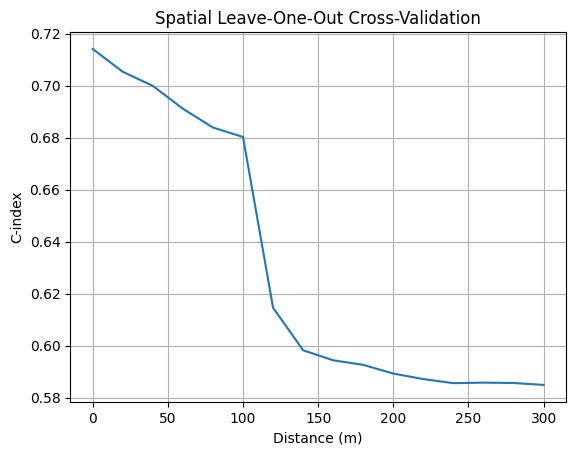

In [22]:
# Plot the c-indices for different distances
plt.plot(range(0, 301, 20), c_indices)
# Add describing labels
plt.xlabel('Distance (m)')
plt.ylabel('C-index')
plt.title('Spatial Leave-One-Out Cross-Validation')
plt.grid()
plt.show()

## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 7NN performance as the prediction distance increases?


2. Do you think the results behave as was somewhat expected? Do they make sense, why?


3. If we require that the 7NN must have at least C-index performance of 0.68, then up to what distance should we trust the 7NN predictions, based on the results?


____

1. As can be seen from the plot between c-index and distance, the performance of the model decreases while the distance increases. At smaller distances, such as 0-40 meters, the c-index remains above 0.7, indicating decent prediction accuracy. The decrease in performance is due to the fact that as distances increase, the spatial similarity between training and test points decreases.

2. Yes, I think these results behave as expected. The performance of the model decreases as the distance between predictions increases because it relies on nearby points to make accurate predictions. On the other hand, when we use points farther away instead of closer points, the spatial relationship weakens, making it more difficult for the model to accurately predict the target values.

3. If we look at the values of the outputs, we can see that with a C-index performance of 0.68, we can use a distance value of 100 to make reliable predictions. Although we want the accuracy of the predictions to be high, we still want to use the maximum value of the distance to find more informative predictions from points further away. If the distance value exceeds 100 meters, the performance of our model starts to drop really fast, making it more unreliable. In short, we want to choose the maximum distance before the "elbow" in the plot.